In [15]:
import keras

In [16]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

In [17]:
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout,Flatten, Lambda
from keras.layers import Conv2D, Activation,AveragePooling2D,MaxPooling2D
from keras.optimizers import RMSprop

In [18]:
from keras import backend as K

In [19]:
num_classes=10
epochs=20

In [20]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [21]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
  
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
  
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)

In [22]:
def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(32, (3,3), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(64, (3,3), activation = 'tanh')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(64,activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(10,activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

In [23]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
# input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

(60000, 28, 28, 1)


In [24]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_net(input_shape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_3 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0   

In [25]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [26]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 55s 510us/step - loss: 0.1399 - accuracy: 0.8203 - val_loss: 0.0681 - val_accuracy: 0.9374
Epoch 2/20
108400/108400 [==============================] - 60s 556us/step - loss: 0.0994 - accuracy: 0.8947 - val_loss: 0.0572 - val_accuracy: 0.9556
Epoch 3/20
108400/108400 [==============================] - 62s 573us/step - loss: 0.0881 - accuracy: 0.9149 - val_loss: 0.0529 - val_accuracy: 0.9560
Epoch 4/20
108400/108400 [==============================] - 61s 560us/step - loss: 0.0802 - accuracy: 0.9273 - val_loss: 0.0506 - val_accuracy: 0.9592
Epoch 5/20
108400/108400 [==============================] - 61s 566us/step - loss: 0.0714 - accuracy: 0.9396 - val_loss: 0.0427 - val_accuracy: 0.9502
Epoch 6/20
108400/108400 [==============================] - 61s 561us/step - loss: 0.0621 - accuracy: 0.9487 - val_loss: 0.0372 - val_accuracy: 0.9581
Epoch 7/20
108400/108400 [=================

In [27]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.19%
* Accuracy on test set: 97.96%


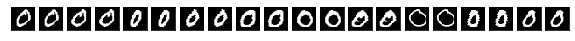

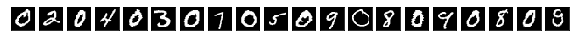

[0.00291521]
[1.1886922]
[0.00209672]
[0.8573111]
[0.00066753]
[1.4425964]
[0.0075882]
[0.6171736]
[0.00406216]
[0.85594094]
[0.00181737]
[1.4346367]
[0.00374064]
[1.2076678]
[0.0005236]
[1.0707093]
[0.00827269]
[0.8566066]
[0.00560664]
[1.4401786]


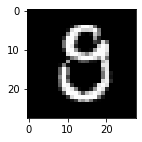

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 20
import tensorflow as tf

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

for i in range(number_of_items):
  print(y_pred[i])
plt.figure(figsize=(20, 2))
plt.imshow(im, cmap="gray")
plt.show()